# Link to Original Git Repository
https://github.com/pranavsinghps1/CASS

# Link to Our Git Repository 
https://github.com/TonyDeng1997/CASS_UIUC598DLH

It contains the checkpoints to be used with our model as well as all the required dependencies

# Environment setup

In [1]:
!pip3 install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip3 install --upgrade git+https://github.com/MedMNIST/MedMNIST.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/MedMNIST/MedMNIST.git to /tmp/pip-req-build-0clm6k16
  Running command git clone --filter=blob:none --quiet https://github.com/MedMNIST/MedMNIST.git /tmp/pip-req-build-0clm6k16
  Resolved https://github.com/MedMNIST/MedMNIST.git to commit db5bff9d0faef4d273896e3cb5542a7000c0239f
  Preparing metadata (setup.py) ... done


# Introduction
*   **Background of the problem:**

  Medical image analysis is vitally important in diagnosing diseases and predicting patient outcomes in general.  However, the effectiveness of deep learning techniques in this realm is often hindered by a lack of labeled data due to issues such as a need for the domain-specific knowledge required for labeling, patient privacy concerns, disease prevalence, and an incomplete understanding of rare or emerging diseases.  This is a challenge when applying deep learning techniques whose performance often relies on large annotated datasets.  Additionally, existing state-of-the-art self-supervised learning techniques often require significant computational resources, such as large batch sizes and extensive training times, to achieve maximum performance.  This oftentimes makes them impractical for many medical imaging applications where compute budgets are limited.

  Current state-of-the-art self-supervised models such as DINO and BYOL can perform well with limited labeled data, but they still require considerable computational resources.  DINO is a teacher and student network, where both the student and the teacher utilize a Vision Transformer (ViT) architecture.  This state-of-the-art, self-supervised model performed comparatively well to its predecessors when trained on unlabeled data.  However, its performance is sometimes dwarfed by supervised models.  Developing a deep learning architecture which performs well with limited labeled data and limited computational resources, could lead to increased patient longevity and general health.  

*   **Paper explanation:**

  The key idea proposed in the CASS paper [1] is to leverage both CNNs and Transformers simultaneously, in a self-supervised learning approach, in order to address the challenges of limited labeled data and high computational cost in medical image analysis.  Unlike existing self-supervised methods, which may use one of these architectures, CASS passes images through a CNN and Transformer in parallel to extract their representations.  These representations are then used to find cosine similarity loss.  The idea is that CNNs and Transformers have different strong suits and by training them in parallel they’re able to learn from one another.  CNNs are translation equivariant and better at capturing local details, while Transformers are better at modeling global context.  By contrasting the features extracted by each architecture, they are able to learn from one another and eventually capture a richer and more useful representation.

  The authors demonstrate that CASS outperforms existing self-supervised methods, like DINO, in terms of F1 Score and Recall value by an average of 3.8% with 1% labeled data, 5.9% with 10% labeled data, and 10.13% with 100% labeled data [1].  It achieved this while requiring 69% less training time on average, compared to DINO.  CASS was also shown to be more robust to changes in batch size and training epochs, which is a key limitation in compute restricted environments.  

  CASS marks an important step towards making self-supervised deep learning models more widely accessible and practically useful for medical image analysis.  It has the potential to accelerate research on rare and emerging diseases where labeled data is scarce, thus advancing the field of computer-aided diagnosis and patient outcome prediction.



# Scope of Reproducibility:

In our project, we aim to validate the following hypotheses:

* **Hypothesis 1:** CASS requires less training time than existing self-supervised models (DINO).

* **Hypothesis 2:** CASS is more robust to changes in batch size and number of epochs.

To test these hypotheses, we will conduct the following experiments:


1.   **Training time comparison:** We will measure and compare the time required to train CASS and DINO on the same dataset.  We will be comparing our results to the DINO results presented in the paper   Unfortunately, our hardware will not exactly match what was used in the paper, so we will need to make a calculated estimation on what the expected difference would be given the differences between our hardware.

2.   **Batch size ablation:** We will evaluate the performance change of CASS when pre-trained with different batch sizes on the same dataset.  We hope to test with batch sizes of 8, 16, and 32, though we may be limited by our hardware to do less.  We will measure the classification performance and compare results between the varying batch sizes.  The paper found that CASS actually performed better with smaller batch sizes and it will be interesting to see if this is reproduced in our own experiments.

3.  **Pre-training epochs ablation:**  We will measure the effect of the number of pre-training epochs on the performance of CASS when trained on identical datasets.  Our goal is to pre-train with epochs of 50, 100, and 200.  As in experiment 2, we will measure the classification performance and compare results between the varying epoch ranges.  The authors found that there were diminishing returns on performance when increasing the epochs beyond 200, so we will focus our experiments on the lower epoch ranges.

We have less computational resources than the authors did and our experiments may be affected.  Because of this, we plan to be flexible in our work and will update our experiments accordingly.  



# Methodology

The following section imports the required packages to run the code

In [1]:
# import  packages you need
import numpy as np
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO, Evaluator
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

print(torch.__version__)

/home/hdeng11/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/
1.11.0+cu102


In [75]:
import os
import numpy as np
import pytorch_lightning as pl
import torch
import pandas as pd
import timm
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import KFold
from torchvision import transforms as tsfm
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torchcontrib.optim import SWA
from torchmetrics import Metric
from torch.utils.tensorboard import SummaryWriter

In [76]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from glob import glob
#from skimage.io import imread
from os import listdir
import time
import copy
from tqdm import tqdm

In [77]:
# General Imports
import matplotlib.pyplot as plt


##  Data


* The dataset we used is https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset as referred as brain tumor mri dataset in the paper
* The detailed statistics are in the following section, it provided traning and testing split for us
* The dataset didn't provide a label csv file, we'll generate label csv file for both training and testing datasets in this section as well

In [78]:
training_base_path = "BrainMRI/Training/"

In [79]:
testing_base_path = "BrainMRI/Testing/"

In [82]:
training_folders = listdir(training_base_path) 
print(len(training_folders))

4


In [86]:
training_folders

['glioma', 'meningioma', 'pituitary', 'notumor']

In [90]:
training_file_count=[]
for i in training_folders:
    path = training_base_path + i
    sub_files = listdir(path)
    training_file_count.append(len(sub_files))


In [91]:
testing_folders = listdir(testing_base_path) 
print(len(testing_folders))

4


In [94]:
testing_folders

['glioma', 'meningioma', 'pituitary', 'notumor']

In [96]:
testing_file_count=[]
for i in testing_folders:
    path = testing_base_path + i
    sub_files = listdir(path)
    testing_file_count.append(len(sub_files))
    print(len(sub_files))

300
306
300
405


In [98]:
total_training_images = 0
for n in range(len(training_folders)):
    patient_id = training_folders[n]
    patient_path = training_base_path  + patient_id
    print(patient_path)
    class_path = patient_path + "/"  + "/"
    subfiles = listdir(class_path)
    total_training_images += len(subfiles)
print("Total Number of Training Images:" + str(total_training_images))

BrainMRI/Training/glioma
BrainMRI/Training/meningioma
BrainMRI/Training/pituitary
BrainMRI/Training/notumor
Total Number of Training Images:5712


In [99]:
total_testing_images = 0
for n in range(len(testing_folders)):
    patient_id = testing_folders[n]
    patient_path = testing_base_path  + patient_id
    print(patient_path)
    class_path = patient_path + "/"  + "/"
    subfiles = listdir(class_path)
    total_testing_images += len(subfiles)
print("Total Number of Testing Images:" + str(total_testing_images))

BrainMRI/Testing/glioma
BrainMRI/Testing/meningioma
BrainMRI/Testing/pituitary
BrainMRI/Testing/notumor
Total Number of Testing Images:1311


In [100]:
testing_file_count

[300, 306, 300, 405]

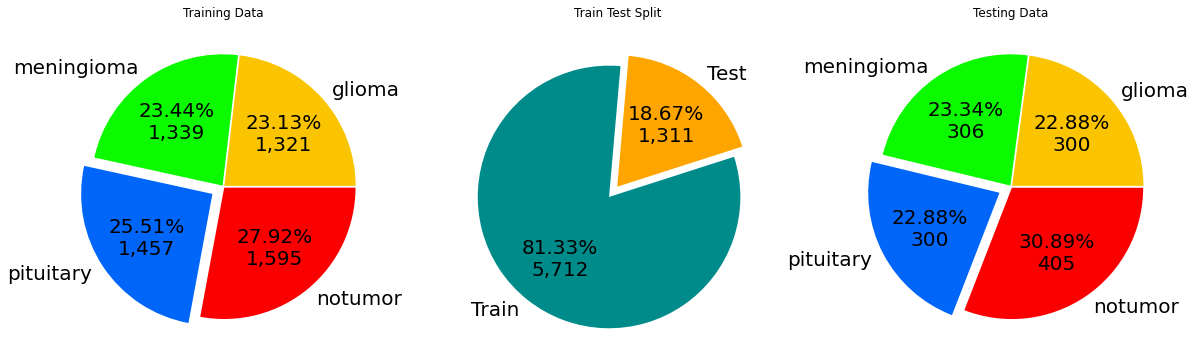

In [101]:
_, ax = plt.subplots(ncols=3, figsize=(20, 14))

# Plotting training data types

ax[0].set_title('Training Data')
ax[0].pie(
    training_file_count,
    labels=training_folders,
    colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p *total_training_images / 100),
    explode=(0.01, 0.01, 0.1, 0.01),
    textprops={'fontsize': 20}
)



ax[1].set_title('Train Test Split')
ax[1].pie(
    [total_training_images, total_testing_images],
    labels=['Train','Test'],
    colors=['darkcyan', 'orange'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum([total_training_images, total_testing_images]) / 100),
    explode=(0.1, 0),
    startangle=85,
    textprops={'fontsize': 20}
)


ax[2].set_title('Testing Data')
ax[2].pie(
    testing_file_count,
    labels=testing_folders,
    colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * total_testing_images / 100),
    explode=(0.01, 0.01, 0.1, 0.01),
    textprops={'fontsize': 20} 
)


plt.show()

In [130]:
data = pd.DataFrame(index=np.arange(0, total_training_images), columns=["path", "target"])

k = 0
for n in range(len(training_folders)):
    patient_id = training_folders[n]
    patient_path = training_base_path  + patient_id
    class_path = patient_path + "/"
    subfiles = listdir(class_path)
    for m in range(len(subfiles)):
        image_path = subfiles[m]
        data.iloc[k]["path"] = class_path + image_path 
        data.iloc[k]["target"] = patient_id
        k += 1  

data.head()

,path,target
0,BrainMRI/Training/glioma/Tr-gl_0162.jpg,glioma
1,BrainMRI/Training/glioma/Tr-gl_0840.jpg,glioma
2,BrainMRI/Training/glioma/Tr-gl_0372.jpg,glioma
3,BrainMRI/Training/glioma/Tr-gl_0343.jpg,glioma
4,BrainMRI/Training/glioma/Tr-gl_0367.jpg,glioma


In [131]:
data['target'].value_counts()/len(data)

notumor       0.279237
pituitary     0.255077
meningioma    0.234419
glioma        0.231268
Name: target, dtype: float64

If would like to take a subset of data, do it here

In [132]:
data_train = data.sample(int(len(data)*1))

In [133]:
data_train['target']

4098     pituitary
871         glioma
3503     pituitary
1765    meningioma
2334    meningioma
           ...    
1317        glioma
2283    meningioma
2004    meningioma
3668     pituitary
607         glioma
Name: target, Length: 5712, dtype: object

In [134]:
#creating CSV for the entire dataset
data_train.to_csv('BrainMRI/training.csv')

Get the class weights to use with focal loss

In [143]:
label_str2num={}
num=0
for i in data_train['target'].unique():
    label_str2num[i]=num
    num+=1
label_str2num 

{'pituitary': 0, 'glioma': 1, 'meningioma': 2, 'notumor': 3}

In [144]:
data={}
for i in data_train['target']:
    if i in data:
        data[i]+=1
    else:
        data[i]=1

In [145]:
data_train['target'].value_counts()

notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: target, dtype: int64

In [146]:
new_data={}
for i in data:
    new_data[label_str2num[i]]=data[i]

In [147]:
new_data

{0: 1457, 1: 1321, 2: 1339, 3: 1595}

In [148]:
from collections import OrderedDict
dist = OrderedDict(sorted(new_data.items()))
dist=dict(dist)

In [149]:

def normalize(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr
  
# assign array and range
array_1d = dist.values()
range_to_normalize = (0.2, 1)
normalized_array_1d = normalize(
    array_1d, range_to_normalize[0], 
  range_to_normalize[1])
  
# display original and normalized array
print("Original Array = ", array_1d)
print("Normalized Array = ", normalized_array_1d)

Original Array =  dict_values([1457, 1321, 1339, 1595])
Normalized Array =  [0.5970802919708029, 0.2, 0.25255474452554744, 1.0]


We repeat the same to generate csv file for test datasets

In [150]:
data = pd.DataFrame(index=np.arange(0, total_testing_images), columns=["path", "target"])

k = 0
for n in range(len(testing_folders)):
    patient_id = testing_folders[n]
    patient_path = testing_base_path  + patient_id
    class_path = patient_path + "/"
    subfiles = listdir(class_path)
    for m in range(len(subfiles)):
        image_path = subfiles[m]
        data.iloc[k]["path"] = class_path + image_path 
        data.iloc[k]["target"] = patient_id
        k += 1  

data.head()

,path,target
0,BrainMRI/Testing/glioma/Te-gl_0262.jpg,glioma
1,BrainMRI/Testing/glioma/Te-gl_0061.jpg,glioma
2,BrainMRI/Testing/glioma/Te-gl_0040.jpg,glioma
3,BrainMRI/Testing/glioma/Te-gl_0287.jpg,glioma
4,BrainMRI/Testing/glioma/Te-gl_0075.jpg,glioma


In [151]:
data['target']

0        glioma
1        glioma
2        glioma
3        glioma
4        glioma
         ...   
1306    notumor
1307    notumor
1308    notumor
1309    notumor
1310    notumor
Name: target, Length: 1311, dtype: object

In [152]:
data.to_csv('BrainMRI/testing.csv')

# Model
This model configures the CASS pretraining algorithm with furthur finetuning with both CNN and Vit. We are reusing the code from here https://github.com/pranavsinghps1/CASS/blob/master/CASS.ipynb and reusing parameters used in paper for draft purpose with minor changes due to different datasets were being used. 

### If you are interested in the result and would not like to run the training again, please jump to the result section, we've saved a checkpoint to use in the result section

In [4]:
import os
import numpy as np
import pytorch_lightning as pl
import torch
import pandas as pd
import timm
import math
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
from torchvision import transforms as tsfm
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torchcontrib.optim import SWA
from torchmetrics import Metric
from torch.utils.tensorboard import SummaryWriter

Copy the label_num2str and cls weight to here

In [5]:
class CFG:
    # data path
    data_path  = 'BrainMRI/training.csv'
    train_imgs_dir  = 'BrainMRI/Training'
    # model info
    # label info
    label_num2str = {0: 'glioma',
                     1: 'pituitary',
                     2:'notumor',
                     3:'meningioma'
                     }
    label_str2num = {'glioma': 0,
                     'pituitary':1,
                     'notumor':2,
                     'meningioma':3
                     }
    fl_alpha = 1.0  # alpha of focal_loss
    fl_gamma = 2.0  # gamma of focal_loss
    cls_weight =  [0.2, 0.5970802919708029, 1.0, 0.25255474452554744] # copy the cls_weight from previous step or just use the variable
    cnn_name='resnet50'
    vit_name='vit_base_patch16_384'
    seed = 77
    num_classes = 4
    batch_size = 16
    t_max = 16
    lr = 1e-3
    min_lr = 1e-6
    n_fold = 6
    num_workers = 8
    gpu_idx = 0
    device = torch.device(f'cuda:{gpu_idx}' if torch.cuda.is_available() else 'cpu')
    gpu_list = [gpu_idx]

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed_everything(77)
cfg=CFG()

Global seed set to 77


Compute Image Mean and Variance to be used for transform function, since we are using the same dataset. We don't really have to run this multiple times.

In [20]:
from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.Resize((384, 384)),  # Resize all images to the same size
    transforms.ToTensor()           # Transform images to PyTorch tensors
])
dataset = datasets.ImageFolder('BrainMRI/Training', transform=transform)

In [21]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=4)

In [22]:
import torch

def get_mean_and_std(dataloader):
    channel_sum, channel_squared_sum, num_elements = 0, 0, 0

    for data, _ in dataloader:
        # Reshape data to be the shape of [B, C, W*H]
        data = data.view(data.size(0), data.size(1), -1)
        # Sum over all pixels and all batches for each channel
        channel_sum += torch.sum(data, dim=[0, 2])
        channel_squared_sum += torch.sum(data ** 2, dim=[0, 2])
        num_elements += data.size(2) * data.size(0)

    # Calculate the mean and variance
    print(num_elements)
    mean = channel_sum / num_elements
    variance = (channel_squared_sum / num_elements) - (mean ** 2)
    std_dev = torch.sqrt(variance)

    return mean, std_dev

# Calculate mean and std
mean, std = get_mean_and_std(dataloader)
print(f'Mean: {mean}')
print(f'Std Deviation: {std}')

842268672
Mean: tensor([0.1857, 0.1857, 0.1858])
Std Deviation: tensor([0.2018, 0.2018, 0.2018])


In [10]:
"""
Define train & valid image transformation
"""
# The mean and std from previous step goes here
DATASET_IMAGE_MEAN = (0.1857, 0.1857, 0.1858)
DATASET_IMAGE_STD = (0.2018, 0.2018, 0.2018)

train_transform = tsfm.Compose([tsfm.Resize((384,384)),
                                tsfm.RandomApply([tsfm.ColorJitter(0.2, 0.2, 0.2),tsfm.RandomPerspective(distortion_scale=0.2),], p=0.3),
                                tsfm.RandomApply([tsfm.ColorJitter(0.2, 0.2, 0.2),tsfm.RandomAffine(degrees=10),], p=0.3),
                                tsfm.RandomVerticalFlip(p=0.3),
                                tsfm.RandomHorizontalFlip(p=0.3),
                                tsfm.ToTensor(),
                                tsfm.Normalize(DATASET_IMAGE_MEAN, DATASET_IMAGE_STD), ])

valid_transform = tsfm.Compose([tsfm.Resize((384,384)),
                                tsfm.ToTensor(),
                                tsfm.Normalize(DATASET_IMAGE_MEAN, DATASET_IMAGE_STD), ])

In [6]:
"""
Define dataset class
"""
class Dataset(Dataset):
    def __init__(self, cfg, img_names: list, labels: list, transform=None):
        self.img_dir = cfg.train_imgs_dir
        self.img_names = img_names
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = self.img_names[idx]
        img = Image.open(img_path).convert('RGB')
        img_ts = self.transform(img)
        label_ts = self.labels[idx]
        return img_ts, label_ts

In [7]:
"""
Define Focal-Loss
"""

class FocalLoss(nn.Module):
    """
    The focal loss for fighting against class-imbalance
    """
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = 1e-12  # prevent training from Nan-loss error
        self.cls_weights = torch.tensor([CFG.cls_weight],dtype=torch.float, requires_grad=False, device=CFG.device)

    def forward(self, logits, target):
        """
        logits & target should be tensors with shape [batch_size, num_classes]
        """
        probs = torch.sigmoid(logits)
        one_subtract_probs = 1.0 - probs
        # add epsilon
        probs_new = probs + self.epsilon
        one_subtract_probs_new = one_subtract_probs + self.epsilon
        # calculate focal loss
        log_pt = target * torch.log(probs_new) + (1.0 - target) * torch.log(one_subtract_probs_new)
        pt = torch.exp(log_pt)
        focal_loss = -1.0 * (self.alpha * (1 - pt) ** self.gamma) * log_pt
        focal_loss = focal_loss * self.cls_weights
        return torch.mean(focal_loss)

In [8]:
"""
Define F1 score metric
"""
class MyF1Score(Metric):
    def __init__(self, cfg, threshold: float = 0.5, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        self.cfg = cfg
        self.threshold = threshold
        self.add_state("tp", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("fp", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("fn", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        assert preds.shape == target.shape
        preds_str_batch = self.num_to_str(torch.sigmoid(preds))
        target_str_batch = self.num_to_str(target)
        tp, fp, fn = 0, 0, 0
        for pred_str_list, target_str_list in zip(preds_str_batch, target_str_batch):
            for pred_str in pred_str_list:
                if pred_str in target_str_list:
                    tp += 1
                if pred_str not in target_str_list:
                    fp += 1

            for target_str in target_str_list:
                if target_str not in pred_str_list:
                    fn += 1
        self.tp += tp
        self.fp += fp
        self.fn += fn

    def compute(self):
        #To switch between F1 score and recall.
        #f1 = 2.0 * self.tp / (2.0 * self.tp + self.fn + self.fp)
        rec = self.tp/(self.tp + self.fn)
        return rec
    
    def num_to_str(self, ts: torch.Tensor) -> list:
        batch_bool_list = (ts > self.threshold).detach().cpu().numpy().tolist()
        batch_str_list = []
        for one_sample_bool in batch_bool_list:
            lb_str_list = [self.cfg.label_num2str[lb_idx] for lb_idx, bool_val in enumerate(one_sample_bool) if bool_val]
            batch_str_list.append(lb_str_list)
        return batch_str_list

In [14]:
df=pd.read_csv(cfg.data_path)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df['path'], df['target'], test_size=0.2, random_state=77)

In [16]:
all_img_names: list = X_train.values.tolist()
all_img_names_valid: list = X_val.values.tolist()

In [17]:
len(all_img_names)

4569

In [18]:
len(all_img_names_valid)

1143

In [19]:
len(all_img_names) + len(all_img_names_valid)

5712

In [20]:
all_img_labels_ts = []
for tmp_lb in y_train:
    tmp_label = torch.zeros([CFG.num_classes], dtype=torch.float)
    label_num=CFG.label_str2num.get(tmp_lb)
    k=int(label_num)
    tmp_label[k] = 1.0
    all_img_labels_ts.append(tmp_label) 

In [21]:
all_img_labels_val_ts = []
for tmp_lb in y_val:
    tmp_label = torch.zeros([CFG.num_classes], dtype=torch.float)
    label_num=CFG.label_str2num.get(tmp_lb)
    k=int(label_num)
    tmp_label[k] = 1.0
    all_img_labels_val_ts.append(tmp_label)

In [23]:
model_cnn = timm.create_model(cfg.cnn_name, pretrained=True)
model_vit = timm.create_model(cfg.vit_name, pretrained=True)
model_cnn.to(device)
model_vit.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn

In [24]:
def ssl_train_model(train_loader,model_vit,criterion_vit,optimizer_vit,scheduler_vit,model_cnn,criterion_cnn,optimizer_cnn,scheduler_cnn,num_epochs):
    writer = SummaryWriter()
    phase = 'train'
    model_cnn.train()
    model_vit.train()
    f1_score_cnn=0
    f1_score_vit=0
    for i in tqdm(range(num_epochs)):
        with torch.set_grad_enabled(phase == 'train'):
            for img,_ in train_loader:
                f1_score_cnn=0
                f1_score_vit=0
                img = img.to(device)
                pred_vit = model_vit(img)
                pred_cnn = model_cnn(img)
                model_sim_loss=loss_fn(pred_vit,pred_cnn)
                loss = model_sim_loss.mean()
                loss.backward()
                optimizer_cnn.step()
                optimizer_vit.step()
                scheduler_cnn.step()
                scheduler_vit.step()
            print('For -',i,'Loss:',loss) 
            writer.add_scalar("Self-Supervised Loss/train", loss, i)
    writer.flush()

In [25]:
optimizer_cnn = SWA(torch.optim.Adam(model_cnn.parameters(), lr= 1e-3))
optimizer_vit = SWA(torch.optim.Adam(model_vit.parameters(), lr= 1e-3))
scheduler_cnn = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_cnn,
                                                                    T_max=16,
                                                                    eta_min=1e-6)
scheduler_vit = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_vit,
                                                                    T_max=16,
                                                                    eta_min=1e-6)

criterion_vit = FocalLoss(cfg.fl_alpha, cfg.fl_gamma)
criterion_cnn = FocalLoss(cfg.fl_alpha, cfg.fl_gamma)

In [26]:
def loss_fn(x, y):
    x =  torch.nn.functional.normalize(x, dim=-1, p=2)
    y =  torch.nn.functional.normalize(y, dim=-1, p=2)
    return 2 - 2 * (x * y).sum(dim=-1)

In [27]:
import random
random.seed(77)
x=0.1 #currently set to use 10% of the labels for reduced label training 
onep=random.sample(range(0, len(X_train)), int(len(X_train)*x))
all_img_names_train = [all_img_names[idx] for idx in onep]
all_img_labels_ts_train = [all_img_labels_ts[idx] for idx in onep]

In [28]:
train_dataset = Dataset(CFG, all_img_names_train,all_img_labels_ts_train, train_transform)
valid_dataset = Dataset(CFG, all_img_names_valid, all_img_labels_val_ts, valid_transform)
train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)

In [29]:
len(valid_dataset)

1143

In [30]:
len(train_dataset)

456

ssl_train_model will return two models (one CNN one Vit) for futurue fine tuning, while DINO only returns one

In [ ]:
#Train SSL
print('Training Cov-T')
#Change Epoche Here
ssl_train_model(train_loader,model_vit,criterion_vit,optimizer_vit,scheduler_vit,model_cnn,criterion_cnn,optimizer_cnn,scheduler_cnn,num_epochs=50)
#Saving SSL Models
print('Saving Cov-T')
torch.save(model_cnn,'./cass-r50-isic.pt')
torch.save(model_vit,'./cass-r50-vit-isic.pt')

Training Cov-T


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

In [32]:
model_cnn=torch.load('cass-r50-isic.pt')
model_vit=torch.load('cass-r50-vit-isic.pt')

In [252]:
from torch.autograd import Variable
#Train Correspong Supervised CNN
print('Fine tunning Cov-T')
model_cnn.fc=nn.Linear(in_features=2048, out_features=4, bias=True)
criterion = FocalLoss(cfg.fl_alpha, cfg.fl_gamma)
metric = MyF1Score(cfg)
val_metric=MyF1Score(cfg)
optimizer = torch.optim.Adam(model_cnn.parameters(), lr = 3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=cfg.t_max,eta_min=cfg.min_lr,verbose=True)
model_cnn.train()
best=0
best_val=0
last_loss=math.inf
writer = SummaryWriter()
#change Epoch Here
for epoch in range(1):
    for images,label in train_loader:
        model_cnn.train()
        images = images.to(device)
        label = label.to(device)
        model_cnn.to(device)
        pred_ts=model_cnn(images)
        print(pred_ts)
        print(label)
        loss = criterion(pred_ts, label)
        score = metric(pred_ts, label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
    train_score=metric.compute()
    logs = {'train_loss': loss, 'Recall': train_score, 'lr': optimizer.param_groups[0]['lr']}
    writer.add_scalar("Supervised-CNN Loss/train", loss, epoch)
    writer.add_scalar("Supervised-CNN Recall/train", train_score, epoch)
   
    print(logs)
    if best < train_score:
        with torch.no_grad():
            best=train_score
            model_cnn.eval()
            total_loss = 0
            for images,label in valid_loader:
                images = images.to(device)
                label = label.to(device)
                model_cnn.to(device)
                pred_ts=model_cnn(images)
                score_val = val_metric(pred_ts,label)
                val_loss = criterion(pred_ts, label)
                total_loss += val_loss.detach()
            avg_loss=total_loss/ len(train_loader)   
            print('Val Loss:',avg_loss)
            val_score=val_metric.compute()
            print('CNN Validation Score:',val_score)
            writer.add_scalar("CNN Supervised F1/Validation", val_score, epoch)
            if avg_loss > last_loss:
                counter+=1
            else:
                counter=0
                    
            last_loss = avg_loss
            if counter > 5:
                print('Early Stopping!')
                break
            else:
                if val_score > best_val:
                    best_val=val_score
                    print('Saving')
                    torch.save(model_cnn,
                        './CASS-CNN-part-ft.pt')
writer.flush()

Fine tunning Cov-T
Adjusting learning rate of group 0 to 3.0000e-04.
tensor([[-0.2224, -0.0796, -0.0395,  0.0047],
        [-0.2016, -0.0637, -0.0475, -0.0132],
        [-0.2842, -0.0978, -0.0022, -0.0042],
        [-0.1506, -0.0919,  0.0201, -0.0029],
        [-0.2032, -0.0587, -0.0537, -0.0144],
        [-0.1869, -0.0571, -0.0454, -0.0252],
        [-0.2704, -0.0947,  0.0181,  0.0343],
        [-0.2470, -0.0571, -0.0424, -0.0040],
        [-0.1797, -0.0699, -0.0362, -0.0193],
        [-0.2350, -0.0880,  0.0200, -0.0152],
        [-0.2367, -0.0918, -0.0361, -0.0323],
        [-0.1786, -0.0518, -0.0241, -0.0411],
        [-0.2378, -0.0537, -0.0488, -0.0198],
        [-0.2625, -0.1105,  0.0104, -0.0248],
        [-0.2353, -0.0843, -0.0563, -0.0045],
        [-0.1884, -0.0600, -0.0535, -0.0146]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0

In [35]:
model_vit=torch.load('cass-r50-vit-isic.pt')
#Train Correspong Supervised Vit
print('Fine tunning Cov-T')
model_vit.head=nn.Linear(in_features=768, out_features=4, bias=True)
criterion = FocalLoss(cfg.fl_alpha, cfg.fl_gamma)
metric = MyF1Score(cfg)
optimizer = torch.optim.Adam(model_vit.parameters(), lr = 3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=cfg.t_max,eta_min=cfg.min_lr,verbose=True)
model_vit.train()
val_metric=MyF1Score(cfg)
writer = SummaryWriter()
from torch.autograd import Variable
best=0
best_val=0
last_loss=math.inf
#Number of Epoches Change here
for epoch in range(1):
    for images,label in train_loader:
        model_vit.train()
        images = images.to(device)
        label = label.to(device)
        model_vit.to(device)
        pred_ts=model_vit(images)
        loss = criterion(pred_ts, label)
        score = metric(pred_ts,label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
    train_score=metric.compute()
    logs = {'train_loss': loss, 'Recall': train_score, 'lr': optimizer.param_groups[0]['lr']}
    writer.add_scalar("Supervised-ViT Loss/train", loss, epoch)
    writer.add_scalar("Supervised-ViT Recall/train", train_score, epoch)
   
    print(logs)
    if best < train_score:
        with torch.no_grad():
            best=train_score
            model_vit.eval()
            total_loss = 0
            for images,label in valid_loader:
                images = images.to(device)
                label = label.to(device)
                model_vit.to(device)
                pred_ts=model_vit(images)
                score_val = val_metric(pred_ts,label)
                val_loss = criterion(pred_ts, label)
                total_loss += val_loss.detach()
            avg_loss=total_loss/ len(train_loader)   
            print('Val Loss:',avg_loss)
            val_score=val_metric.compute()
            print('ViT Validation Score:',val_score)
            writer.add_scalar("ViT Supervised F1/Validation", val_score, epoch)
            if avg_loss > last_loss:
                counter+=1
            else:
                counter=0
                    
            last_loss = avg_loss
            if counter > 5:
                print('Early Stopping!')
                break
            else:
                if val_score > best_val:
                    best_val=val_score
                    print('Saving')
                    torch.save(model_vit,
                        './CASS-ViT-part-ft.pt')
writer.flush()

Fine tunning Cov-T
Adjusting learning rate of group 0 to 3.0000e-04.
Adjusting learning rate of group 0 to 2.9713e-04.
Adjusting learning rate of group 0 to 2.8862e-04.
Adjusting learning rate of group 0 to 2.7480e-04.
Adjusting learning rate of group 0 to 2.5621e-04.
Adjusting learning rate of group 0 to 2.3356e-04.
Adjusting learning rate of group 0 to 2.0771e-04.
Adjusting learning rate of group 0 to 1.7967e-04.
Adjusting learning rate of group 0 to 1.5050e-04.
Adjusting learning rate of group 0 to 1.2133e-04.
Adjusting learning rate of group 0 to 9.3289e-05.
Adjusting learning rate of group 0 to 6.7442e-05.
Adjusting learning rate of group 0 to 4.4788e-05.
Adjusting learning rate of group 0 to 2.6195e-05.
Adjusting learning rate of group 0 to 1.2380e-05.
Adjusting learning rate of group 0 to 3.8726e-06.
Adjusting learning rate of group 0 to 1.0000e-06.
Adjusting learning rate of group 0 to 3.8726e-06.
Adjusting learning rate of group 0 to 1.2380e-05.
Adjusting learning rate of grou

# Results
In this section, you should finish training your model training or loading your trained model. That is a great experiment! You should share the results with others with necessary metrics and figures.

Please test and report results for all experiments that you run with:

*   specific numbers (accuracy, AUC, RMSE, etc)
*   figures (loss shrinkage, outputs from GAN, annotation or label of sample pictures, etc)


In [ ]:
# metrics to evaluate my model

# plot figures to better show the results

# it is better to save the numbers and figures for your presentation.

In [153]:
class CFG:
    # data path
    data_path  = 'BrainMRI/testing.csv'
    train_imgs_dir  = 'BrainMRI/Testing'
    # model info
    # label info
    label_num2str = {0: 'glioma',
                     1: 'pituitary',
                     2:'notumor',
                     3:'meningioma'
                     }
    label_str2num = {'glioma': 0,
                     'pituitary':1,
                     'notumor':2,
                     'meningioma':3
                     }
    fl_alpha = 1.0  # alpha of focal_loss
    fl_gamma = 2.0  # gamma of focal_loss
    cls_weight = [0.2, 0.5970802919708029, 1.0, 0.25255474452554744] # copy the cls_weight from previous step or just use the variable
    cnn_name='resnet50'
    vit_name='vit_base_patch16_384'
    seed = 77
    num_classes = 4
    batch_size = 16
    t_max = 16
    lr = 1e-3
    min_lr = 1e-6
    n_fold = 6
    num_workers = 8
    gpu_idx = 0
    device = torch.device(f'cuda:{gpu_idx}' if torch.cuda.is_available() else 'cpu')
    gpu_list = [gpu_idx]

In [154]:
class Dataset(Dataset):
    def __init__(self, cfg, img_names: list, labels: list, transform=None):
        self.img_dir = cfg.train_imgs_dir
        self.img_names = img_names
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = self.img_names[idx]
        img = Image.open(img_path).convert('RGB')
        img_ts = self.transform(img)
        label_ts = self.labels[idx]
        return img_ts, label_ts

In [155]:
class FocalLoss(nn.Module):
    """
    The focal loss for fighting against class-imbalance
    """
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = 1e-12  # prevent training from Nan-loss error
        self.cls_weights = torch.tensor([CFG.cls_weight],dtype=torch.float, requires_grad=False, device=CFG.device)

    def forward(self, logits, target):
        """
        logits & target should be tensors with shape [batch_size, num_classes]
        """
        probs = torch.sigmoid(logits)
        one_subtract_probs = 1.0 - probs
        # add epsilon
        probs_new = probs + self.epsilon
        one_subtract_probs_new = one_subtract_probs + self.epsilon
        # calculate focal loss
        log_pt = target * torch.log(probs_new) + (1.0 - target) * torch.log(one_subtract_probs_new)
        pt = torch.exp(log_pt)
        focal_loss = -1.0 * (self.alpha * (1 - pt) ** self.gamma) * log_pt
        focal_loss = focal_loss * self.cls_weights
        return torch.mean(focal_loss)

In [156]:
"""
Define F1 score metric
"""
class MyF1Score(Metric):
    def __init__(self, cfg, threshold: float = 0.5, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        self.cfg = cfg
        self.threshold = threshold
        self.add_state("tp", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("fp", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("fn", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        assert preds.shape == target.shape
        preds_str_batch = self.num_to_str(torch.sigmoid(preds))
        target_str_batch = self.num_to_str(target)
        tp, fp, fn = 0, 0, 0
        for pred_str_list, target_str_list in zip(preds_str_batch, target_str_batch):
            for pred_str in pred_str_list:
                if pred_str in target_str_list:
                    tp += 1
                if pred_str not in target_str_list:
                    fp += 1

            for target_str in target_str_list:
                if target_str not in pred_str_list:
                    fn += 1
        self.tp += tp
        self.fp += fp
        self.fn += fn

    def compute(self):
        #f1 = 2.0 * self.tp / (2.0 * self.tp + self.fn + self.fp)
        rec = self.tp/(self.tp + self.fn)
        return rec
    
    def num_to_str(self, ts: torch.Tensor) -> list:
        batch_bool_list = (ts > self.threshold).detach().cpu().numpy().tolist()
        batch_str_list = []
        for one_sample_bool in batch_bool_list:
            lb_str_list = [self.cfg.label_num2str[lb_idx] for lb_idx, bool_val in enumerate(one_sample_bool) if bool_val]
            if len(lb_str_list) == 0:
                lb_str_list = ['healthy']
            batch_str_list.append(lb_str_list)
        return batch_str_list

In [157]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed_everything(77)
cfg=CFG()

Global seed set to 77


We use the same Image Mean and STD as in the training steps 

In [158]:
DATASET_IMAGE_MEAN = (0.1857, 0.1857, 0.1858)
DATASET_IMAGE_STD = (0.2018, 0.2018, 0.2018)

In [159]:
test_transform = tsfm.Compose([tsfm.Resize((384,384)),
                                tsfm.RandomApply([tsfm.ColorJitter(0.2, 0.2, 0.2),tsfm.RandomPerspective(distortion_scale=0.2),], p=0.3),
                                tsfm.RandomApply([tsfm.ColorJitter(0.2, 0.2, 0.2),tsfm.RandomAffine(degrees=10),], p=0.3),
                                tsfm.RandomVerticalFlip(p=0.3),
                                tsfm.RandomHorizontalFlip(p=0.3),
                                tsfm.ToTensor(),
                                tsfm.Normalize(DATASET_IMAGE_MEAN, DATASET_IMAGE_STD), ])



In [160]:
df=pd.read_csv('BrainMRI/testing.csv')

In [161]:
df['target'].value_counts()

notumor       405
meningioma    306
glioma        300
pituitary     300
Name: target, dtype: int64

In [162]:
all_img_names: list = df['path'].values.tolist()

In [163]:
len(all_img_names)

1311

In [164]:
all_img_labels_ts = []
for tmp_lb in df['target']:
    tmp_label = torch.zeros([CFG.num_classes], dtype=torch.float)
    label_num=CFG.label_str2num.get(tmp_lb)
    k=int(label_num)
    tmp_label[k] = 1.0
    all_img_labels_ts.append(tmp_label) 

In [165]:
test_dataset = Dataset(CFG, all_img_names,all_img_labels_ts, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers, drop_last=True)

In [166]:
model=torch.load('./CASS-ViT-part-ft.pt')

In [168]:
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn

In [169]:
criterion = FocalLoss(cfg.fl_alpha, cfg.fl_gamma)
metric = MyF1Score(cfg)
val_metric=MyF1Score(cfg)
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=cfg.t_max,eta_min=cfg.min_lr,verbose=True)
model.eval()

with torch.no_grad():
    for images,label in test_loader:
        images = images.to(device)
        label = label.to(device)
        model.to(device)
        pred_ts=model(images)
        loss = criterion(pred_ts, label)
        score = metric(pred_ts, label)
test_score=metric.compute()
logs = {'train_loss': loss, 'Recall': test_score, 'lr': optimizer.param_groups[0]['lr']}
print(logs)

Adjusting learning rate of group 0 to 3.0000e-04.


/home/hdeng11/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (MyF1Score). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


{'train_loss': tensor(0.2133, device='cuda:0'), 'Recall': tensor(0.3094), 'lr': 0.0003}


## Model comparison

In [2]:
# compare you model with others
# you don't need to re-run all other experiments, instead, you can directly refer the metrics/numbers in the paper

#Not applicable in draft since we are running with only one epoche

# Discussion

We set up a local test environment to test whether our CASS implementation was capable of running successfully for a single epoch with a batch size of 16.  This was successful and a single epoch took about 30 minutes using a GPU with 22GB RAM.  After training for one epoch on the Brain MRI dataset, we achieved a Recall value of 0.3 which is only slightly better than a naive random baseline.  This was to be expected given the extremely limited training duration and only served as a sanity check that our implementation was functioning correctly.  We believe this is a strong indicator that this paper is reproducible.  

Our next step is to scale up our training process and run the model for a sufficient number of epochs (50+) in order to meaningfully compare our results with those reported by the authors.  This is a potential challenge given that our GPU has less than half of the memory of the GPU used by the authors.  This will likely restrict our batch size to less than 20, which is not ideal.  To address this issue, we’re considering setting up a cloud environment with more powerful GPUs so that we can reduce the overall training time and use a larger batch size.  We will assess the feasibility and cost effectiveness of that option in the coming days and make a decision based on the available resources and time constraints.

We also plan to evaluate using other relevant metrics, like F1 score.  If time permits, we may extend our study to another dataset, that being the DermoFIT dataset which is a private, paid dataset.  We have applied for access and are still waiting for a decision.


# References

1.  Singh, P. and Cirrone, J., “Efficient Representation Learning for Healthcare with Cross-Architectural Self-Supervision”, <i>arXiv e-prints</i>, 2023. 

